<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Цель" data-toc-modified-id="Цель-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Цель</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#План-действий" data-toc-modified-id="План-действий-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>План действий</a></span></li></ul></li><li><span><a href="#Обзор-и-анализ-данных" data-toc-modified-id="Обзор-и-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор и анализ данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Поиск-модели" data-toc-modified-id="Поиск-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Поиск модели</a></span><ul class="toc-item"><li><span><a href="#Prophet" data-toc-modified-id="Prophet-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#Holt-Winters" data-toc-modified-id="Holt-Winters-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Holt-Winters</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBM</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Поиск модели ML для предсказания количества необходимых такси в аэропортах в следюущий час.

### Цель

На основе данных о заказах такси в аэропортах за прошлые полгода подобрать модель ML для прогноза необходимого их количества в следующий 1 час, чтобы привлекать больше водителей в периоды пиковой нагрузки.

### Описание данных

Датасет содержит данные по заказам такси за период с марта по август 2018г., с интервалом в 10мин.

`datetime` - дата и время  
`num_orders` - количество заказов такси за текущий интервал


### План действий

- загрузка данных и необходимых библиотек
- обзор, предобработка, анализ данных (пропуски, равномерность, стационарность)
- подготовка датасета, обучение и оценка моделей prophet, holt-winters, LGBM
- выводы

## Обзор и анализ данных

In [1]:
#!pip3 install prophet -U

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
import scipy.stats as scs
from scipy.special import boxcox, inv_boxcox
import numpy as np

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from lightgbm import LGBMRegressor
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
import copy
from tqdm import tqdm

In [3]:
try: df = pd.read_csv('datasets/taxi.csv', parse_dates=True, index_col='datetime')
except FileNotFoundError:
    df = pd.read_csv('taxi.csv', parse_dates=True, index_col='datetime')

In [4]:
df.head(2)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14


In [5]:
#данные с марта по август, без пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
#данные эквидистантны (разница между соседними timestamp всегда одна и та же)
(pd.Series(df.index).diff()).unique()

array([       'NaT', 600000000000], dtype='timedelta64[ns]')

In [7]:
#для нашей задачи необходимо ресемплирование по 1 часу
df = df.resample('1H').sum()

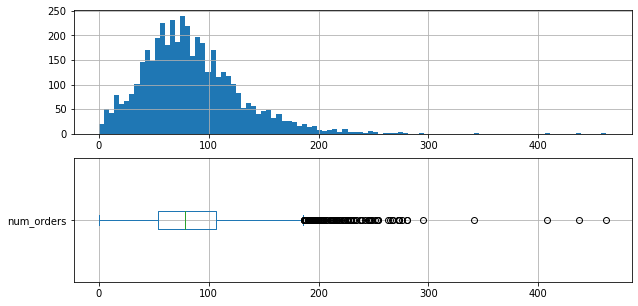

In [8]:
#число заказов - положительно, есть выбросы (скорее всего связанные с праздниками), в среднем 80 такси/час.
fig, (ax1,ax2) = plt.subplots(2, figsize=(10,5))
df.num_orders.hist(ax=ax1,bins=100)
df.num_orders.plot(ax=ax2,kind='box', vert=False, grid=True)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


In [10]:
decomposed = seasonal_decompose(df.num_orders)

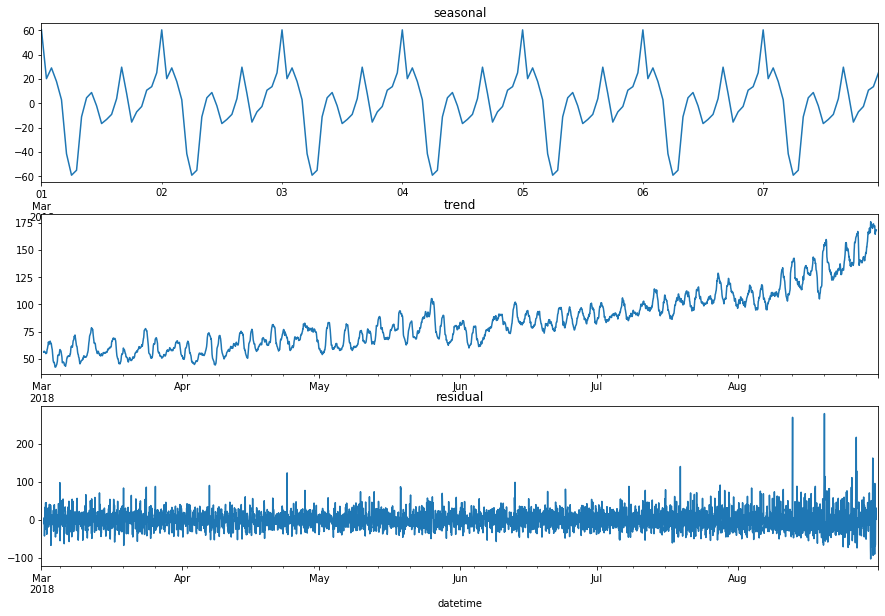

In [11]:
#видна суточная периодичность (минимум в 06:00 и максимум в 00:00) и тренд на увеличение
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15, 10))
decomposed.seasonal[:'2018-03-07'].plot(ax=ax1, title='seasonal')
decomposed.trend.plot(ax=ax2, title='trend')
decomposed.resid.plot(ax=ax3, title='residual')

In [12]:
#можно отвергнуть гипотезу о нестационарности ряда при уровне значимости 5% (вместе с тем
# seasonal_decomposition показывает тренд на увеличение)
test = adfuller(df.num_orders)
display(f'p-value: {test[1]:.3f}')

'p-value: 0.029'

'lmbda_boxcox: 0.49959816626526066'

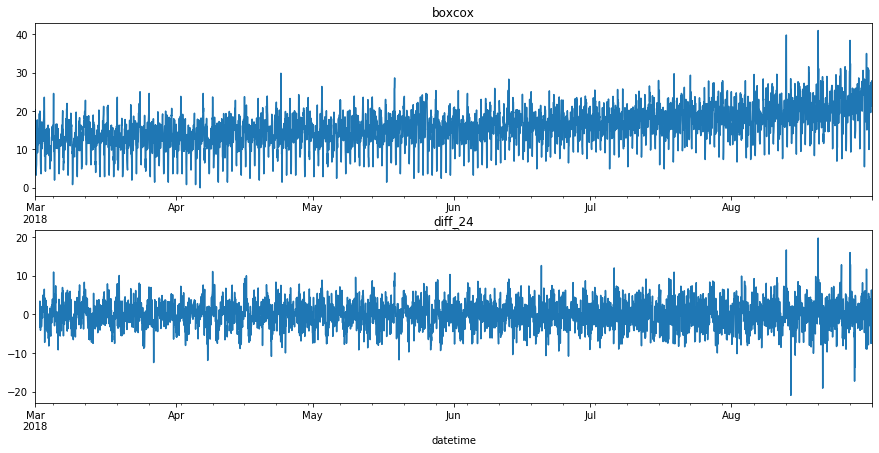

In [13]:
#чтобы сделать ряд более стационарным, можно сделать Бокс-Кокс преобразование (выравнивает дисперсии)
#и продифференцировать (вычесть желаемый период)
#полученными данными пользоваться не будем - т.к. тест Дики-Фуллера и так показывает стационарность
data_boxcox, lmbda = scs.boxcox(df.num_orders+1)
display(f'lmbda_boxcox: {lmbda}')
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 7))
pd.Series(data_boxcox, index=df.index).plot(ax=ax1, title='boxcox')
pd.Series(data_boxcox, index=df.index).diff(24).plot(ax=ax2, title='diff_24')

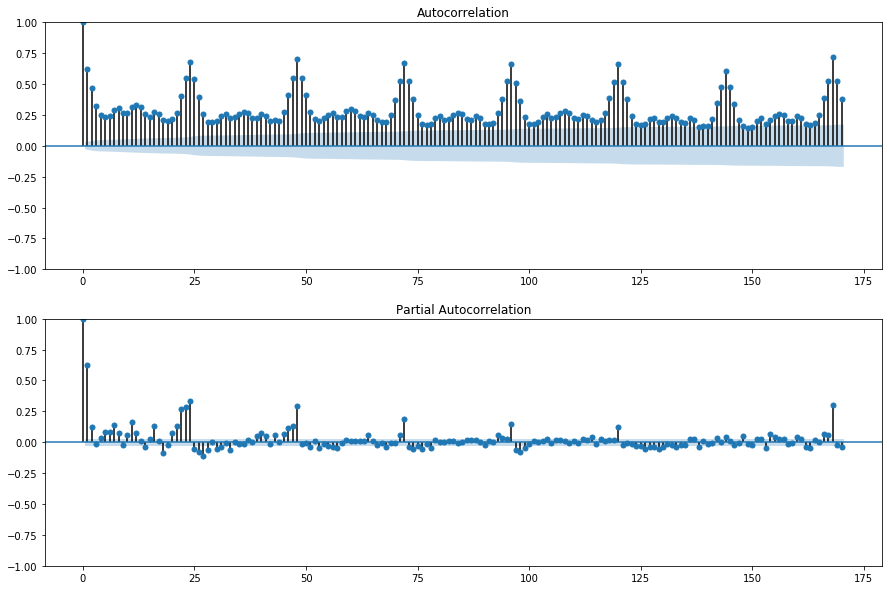

In [14]:
#автокорреляция - видна суточная периодичность (24 часа)
#частичная автокорреляция - видна недельная периодичность (7 суток)
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 10))
plot_acf(df.num_orders, lags=170, ax=ax1)
plot_pacf(df.num_orders, lags=170, ax=ax2);

### Выводы

- данные представлены за период с марта по август с периодом в 10мин
- данные эквидистантны, без пропусков
- обнаружена суточная и недельная периодичности, проглядывается тренд на увеличение, однако тест Дики-Фуллера гипотезу о нестационарности скорее всего отвергает (`p_value = 3%`)
- 06:00 - самое спокойное время в аэропорту, 00:00 - самое загруженное
- в среднем требуется 80 такси/час

## Поиск модели

Рассматриваемые ниже модели требуют на входе датасеты разного формата, потому каждый раз будем готовить их заново, учитывая особенности модели, с которой работаем.

### Prophet

In [15]:
prophet = Prophet(weekly_seasonality=50, daily_seasonality=25, seasonality_mode = 'multiplicative')
df_prophet = df.reset_index().copy()
df_prophet.columns = ['ds','y']
df_prophet_train, df_prophet_test = train_test_split(df_prophet, test_size=.1, shuffle=False)

In [16]:
prophet.fit(df_prophet_train)

15:57:02 - cmdstanpy - INFO - Chain [1] start processing
15:57:05 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = prophet.make_future_dataframe(periods = df_prophet_test.shape[0], freq='H')
df_prophet_predicted = prophet.predict(future).tail(df_prophet_test.shape[0])
df_prophet_ = df_prophet_test.set_index('ds').join(df_prophet_predicted.set_index('ds')[['yhat']])

In [18]:
display(f'RMSE: {mean_squared_error(df_prophet_.y, df_prophet_.yhat, squared=False):.2f}')

'RMSE: 41.44'

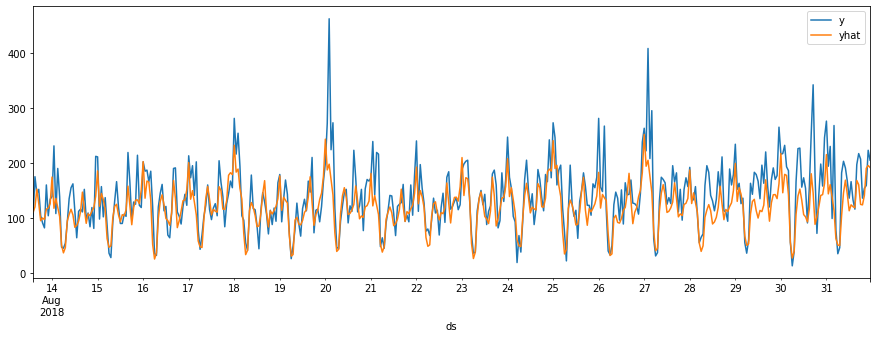

In [19]:
df_prophet_.plot(figsize=(15,5))

### Holt-Winters

In [20]:
df_train, df_test = train_test_split(df, test_size=.1, shuffle=False)

In [21]:
#подбор гиперпараметров: вложенные циклы по 4 гиперпараметрам, внутри циклов через TimeSeriesSplit расчитывается
#средний (по всем сплитам) RMSE. Некоторые гиперпараметры требуют от датасета положительных значений, потому
#прибавляем и отнимаем 1
mul_add = ['mul','add']
periods = [24,168]
use_boxcox = [True, False]

params_all = []
scores_all = []
models_all = []
for i in tqdm(mul_add):
    for j in mul_add:
        for k in periods:
            for l in use_boxcox:
                rmse_cv = []
                params=dict()
                for train_index, test_index in TimeSeriesSplit().split(df_train):
                    X, y = df_train.iloc[train_index], df_train.iloc[test_index]
                    holtwinters = ExponentialSmoothing(X+1, trend=i, seasonal=j, seasonal_periods=k,
                                                       use_boxcox=l).fit()
                    y_pred = holtwinters.predict(y.index[0], y.index[-1])-1
                    rmse_cv.append(mean_squared_error(y, y_pred, squared=False))
                rmse = np.mean(rmse_cv)
                params['trend']=i
                params['seasonal']=j
                params['seasonal_periods']=k
                params['use_boxcox']=l
                params_all.append(params)
                scores_all.append(rmse)                        

100%|██████████| 2/2 [03:53<00:00, 116.55s/it]


In [22]:
#оптимальные гиперпараметры
best_params = pd.DataFrame(
    {'params':params_all, 'scores': scores_all}).sort_values('scores').iloc[0].params
best_params

{'trend': 'add',
 'seasonal': 'add',
 'seasonal_periods': 168,
 'use_boxcox': True}

In [23]:
#проверка модели на тестовой выборке
holtwinters = ExponentialSmoothing(
    df_train+1, trend=best_params['trend'], seasonal=best_params['seasonal'], 
    seasonal_periods=best_params['seasonal_periods'], use_boxcox=best_params['use_boxcox']).fit()
df_predicted = holtwinters.predict(df_test.index[0], df_test.index[-1])-1

In [24]:
display(f'RMSE: {mean_squared_error(df_test, df_predicted, squared=False):.2f}')

'RMSE: 37.25'

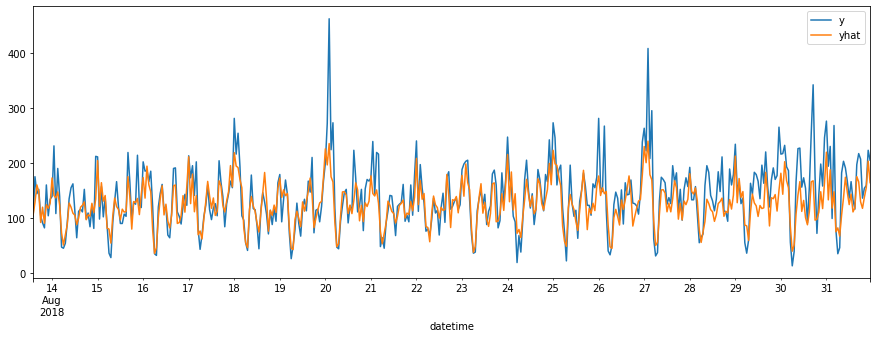

In [25]:
df_test.rename(columns={'num_orders':'y'}).join(pd.DataFrame({'yhat':df_predicted})).plot(figsize=(15,5))

### LGBM

In [26]:
df_lgbm=df.copy()

In [27]:
#создадим новые признаки: lag features (за 24 прошедшие часа), rolling features (за 7 прошедших суток)
def make_features(data=df_lgbm, hours_past=24, days_past=7):
    data = data.copy()
    for _ in range(1,hours_past+1):
        
        data[f'previous_{_}'] = data.num_orders.shift(_)
    for _ in range(1,days_past+1):
        window = data.num_orders.shift(_*24).rolling(24, min_periods=24)
        data[f'mean_rolling_day_{_}'] = window.mean()
        data[f'min_rolling_day_{_}'] = window.min()
        data[f'max_rolling_day_{_}'] = window.max()
        data[f'std_rolling_day_{_}'] = window.std()
        
    return data.dropna()

In [28]:
_ = make_features()
X = _.drop('num_orders', axis=1)
y = _.num_orders

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)

In [30]:
#подбор гиперпараметров
param_grid = {
    'max_depth': [10,20], 
    'num_leaves': [30,60], 
    'learning_rate': [.1,.07,.15], 
    'n_estimators': [50,100,200]}

search = RandomizedSearchCV(
    cv=TimeSeriesSplit(), estimator=LGBMRegressor(), param_distributions=param_grid, scoring='neg_root_mean_squared_error',
    refit=True, return_train_score=False, verbose=10, n_jobs=-1, n_iter=50, random_state=42)
search.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.07, 0.15],
                                        'max_depth': [10, 20],
                                        'n_estimators': [50, 100, 200],
                                        'num_leaves': [30, 60]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [31]:
predicted = search.best_estimator_.predict(X_test)
display(f'RMSE: {mean_squared_error(y_test, predicted, squared=False):.2f}')

'RMSE: 40.67'

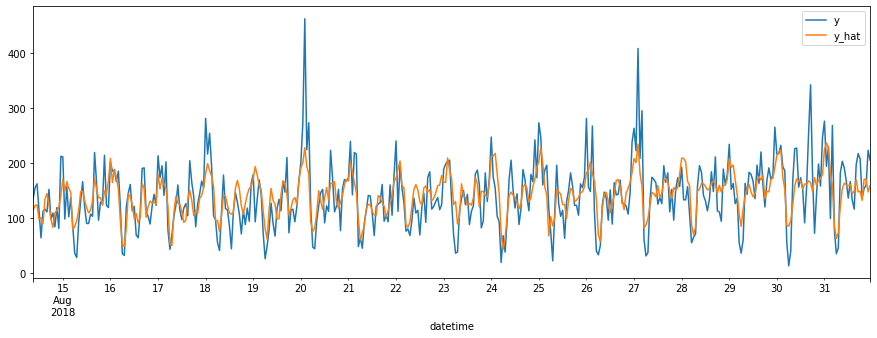

In [32]:
pd.DataFrame({'y':y_test.values, 'y_hat':predicted}, index=y_test.index).plot(figsize=(15,5))

## Вывод

Лучшей показала себя модель `Holt-Winters` (тройное экспоненциальное сглаживание) `RMSE = 37.2`.  
Целевую планку в `RMSE < 48` преодолели все три рассмотренные модели.  
Для получения ещё большей точности можно попробовать убрать тренд и выровнять дисперсии (дифференцирование и Бокс-Кокс) и воспользоваться пакетом автоматического создания признаков (`tsfresh` - осторожно, требователен к RAM).

- поиск модели осуществлялся по данным за полгода (март-август 2018)
- обнаружена суточная и недельная периодичности, проглядывается тренд на увеличение, тест Дики-Фуллера гипотезу о нестационарности скорее всего отвергает (`p_value = 3%`)
- 06:00 - самое спокойное время в аэропорту, 00:00 - самое загруженное
- в среднем требуется 80 такси/час